# 0. Import packages

In [1]:
import sys
import os

PWD_PATH = os.getcwd()
# appending a path


import glob
import xarray as xr
import numpy as np
import pandas as pd


from functions_cfosat_env import get_indices_macrocycles
from Misc_functions import HandlerColumnLines
from altimetry_waveforms_functions import *

# --- plotting and interactive stuff ----------------------
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors

import matplotlib.collections as mcol # to plot multilines


cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

PATH_save0=''


# 1. Load CFOSAT data

In [2]:
islocal = 1
nbeam=2

# These are the original CFOSAT data files 
#filel1a = 'CFO_OP05_SWI_L1A____F_20200214T090559_20200214T103900.nc'
#file_L2 = 'CFO_OP05_SWI_L2_____F_20200214T090559_20200214T103900.nc'

# These are pieces of the original files (to reduce the size of this sample) 
filel1a = 'CFO_OP05_SWI_L1A____F_20200214T090559_20200214T103900_cut.nc'
file_L2 = 'CFO_OP05_SWI_L2_____F_20200214T090559_20200214T103900_cut.nc'


dsl1a = xr.open_dataset(filel1a,decode_times=False)
DS = xr.open_dataset(file_L2,decode_times=False)


In [3]:
dsl1a

<xarray.Dataset> Size: 755MB
Dimensions:                           (n_mcycles: 1765, n_beam: 6,
                                       n_swath_0: 256, n_swath_1: 755,
                                       n_swath_2: 933, n_swath_3: 2771,
                                       n_swath_4: 2639, n_swath_5: 3215,
                                       n_beam0: 1, n_swath_0_cor: 512, n_tim: 2)
Dimensions without coordinates: n_mcycles, n_beam, n_swath_0, n_swath_1,
                                n_swath_2, n_swath_3, n_swath_4, n_swath_5,
                                n_beam0, n_swath_0_cor, n_tim
Data variables: (12/80)
    alpha_r_p                         (n_mcycles, n_beam) float32 42kB ...
    alpha_t_p                         (n_mcycles, n_beam) float32 42kB ...
    altitude                          (n_mcycles, n_beam) float64 85kB ...
    att_code                          (n_mcycles, n_beam) float32 42kB ...
    cal_ratio_0                       (n_mcycles, n_swath_0) float32 2MB ...
    cal_ratio_1                       (n_mcycles, n_swath_1) float32 5MB ...
    ...                                ...
    reliable_swath_1                  (n_swath_1) float32 3kB ...
    reliable_swath_2                  (n_swath_2) float32 4kB ...
    reliable_swath_3                  (n_swath_3) float32 11kB ...
    reliable_swath_4                  (n_swath_4) float32 11kB ...
    reliable_swath_5                  (n_swath_5) float32 13kB ...
    time_nr                           (n_mcycles, n_beam, n_tim) int64 169kB ...
Attributes: (12/50)
    history:                              Mon Mar 18 16:54:15 2024: ncks -d n...
    institution:                          CNES
    references:                           DDI CFOSAT - Ref. CF_GSFR-ICD-1094-...
    title:                                SWIM_L1A____product
    Conventions:                          CF-1.7
    date_created:                         2020-12-23T15:56:14Z
    ...                                   ...
    antenna_rotation_speed:               5.6
    beam_elevation:                       0.000000;2.300000;3.700000;5.550000...
    beam_width:                           1.585000;1.530000;1.740000;1.860000...
    signal_sampling_in_radar_geometry:    0.374741;1.498962;1.498962;0.749481...
    signal_resolution_in_radar_geometry:  0.468426;1.873703;1.873703;0.936851...
    NCO:                                  4.7.2

# 1. Plots

L2 box  9 corresponds to these indices for L1A: [403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420
 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438
 439 440 441 442 443 444 445 446 447 448 449 450 451 452]
box index: 9  number of wfs: (50,)
(1, 50, 256)
Noise level? 0.0010177956
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00022458364 222.5
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00022458364 222.5
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00022458364 222.5
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00022458364 222.5
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00022458364 222.

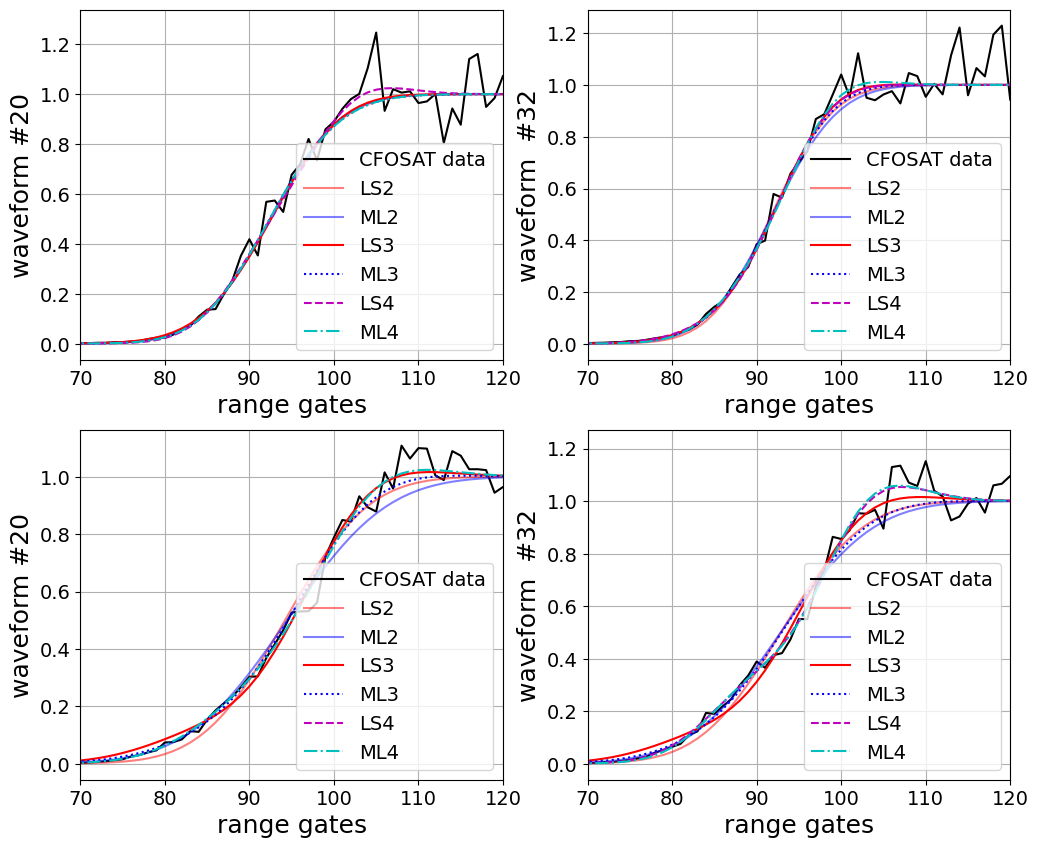

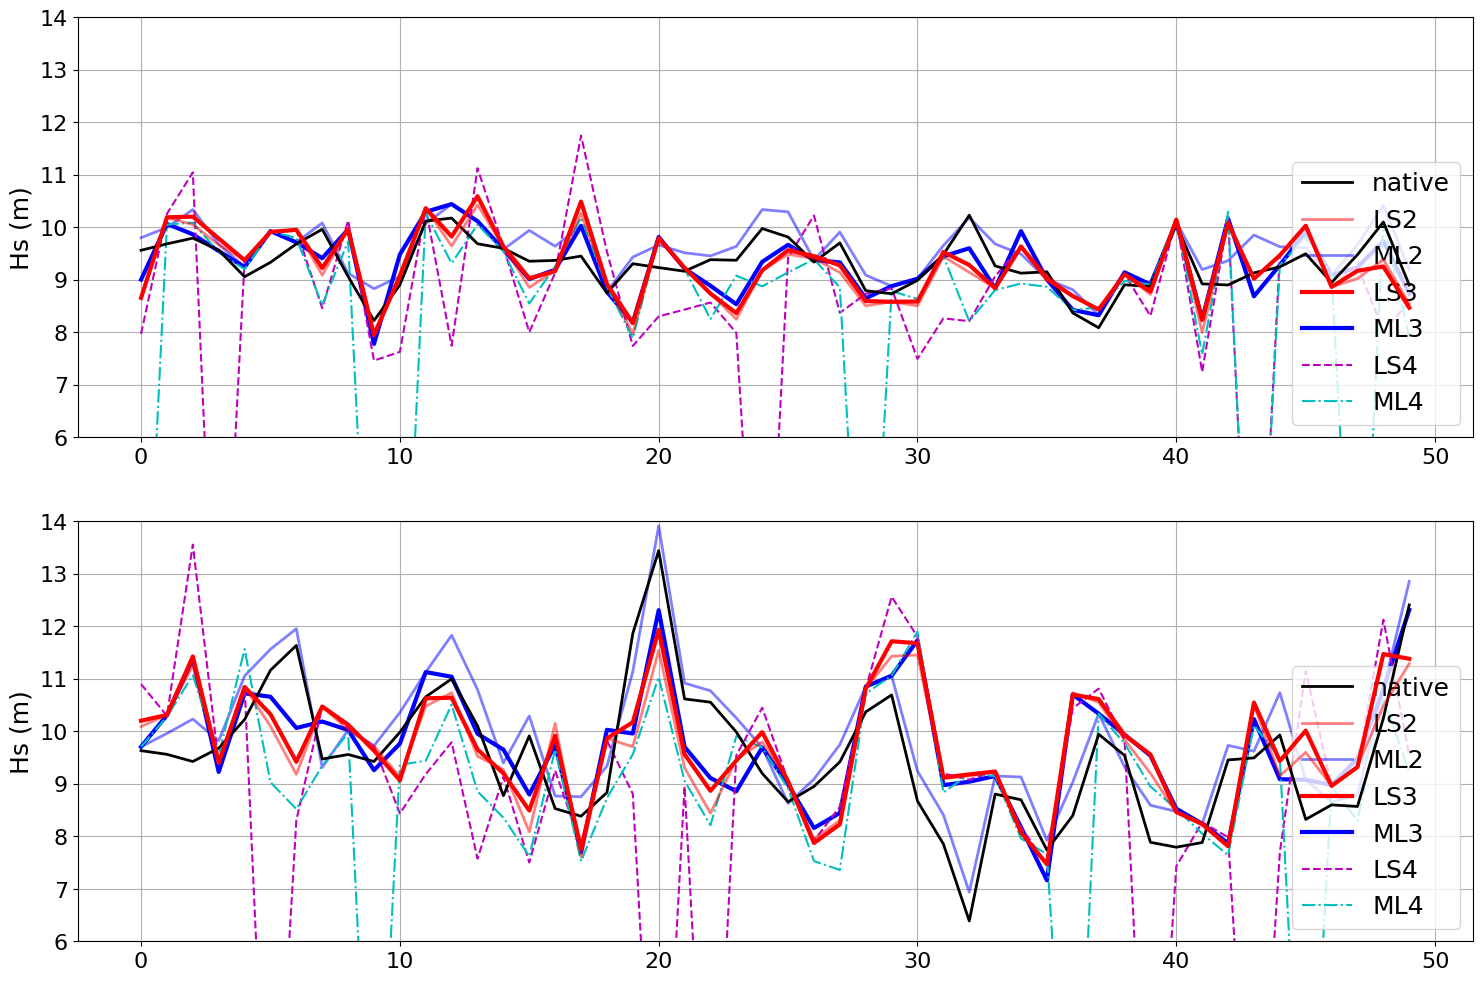

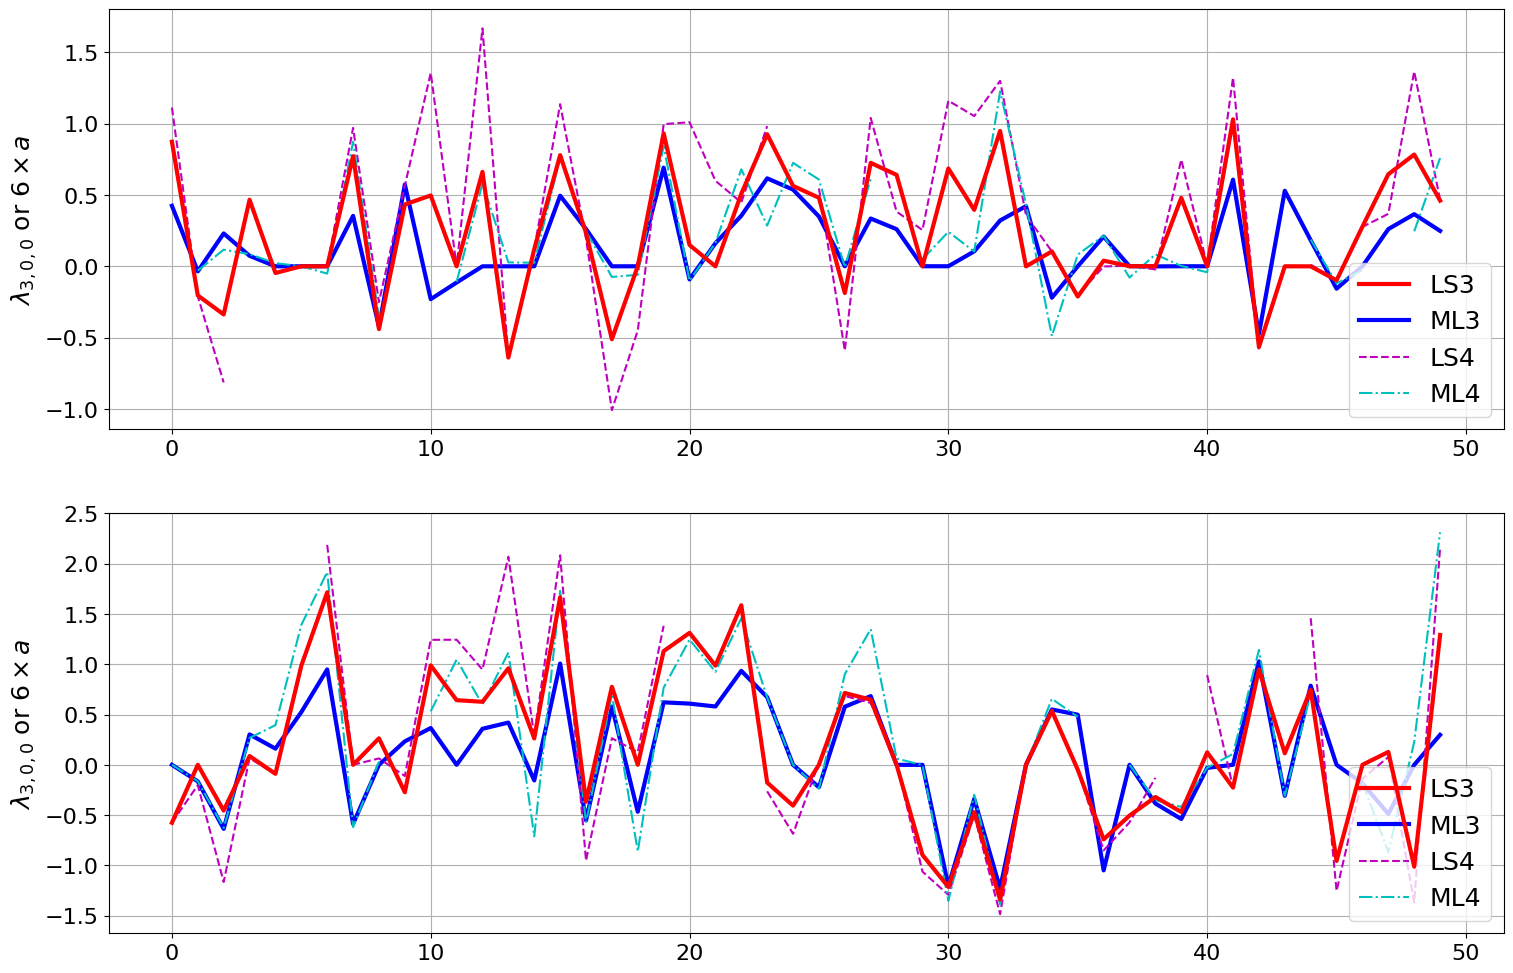

In [4]:
############# Define satellite parameters
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.

# choice of satellite 
ialti = 0

theta3dB=theta3dBs[ialti]
alti_sat = Altis[ialti]
bandwidth = BW[ialti]
bandx     = BX[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
nameSat = namesAltis[ialti]
tau=1E9/bandwidth

clight = 299792458
dr = clight * 1/(2*bandwidth)
Rearth=6378.1363*(10**3)      #Earth radius

Earth_sphericity_coeff = (1+alti_sat/Rearth)


is_echo_l1a = 1

if is_echo_l1a:
   wf_model='wf_erf2D'
   var = 'echo_l1a_0'
   max_range_fit=180
   min_range_fit=80
   nominal_tracking_gate=89
   minLS=65
   minLS=64;max_range_fit=192
else:
   wf_model='wf_brown'
   var = 'echo_l1_0'
   max_range_fit=300
   min_range_fit=205
   nominal_tracking_gate=220
   minLS=200

range_offset = nominal_tracking_gate*dr  # number of meters above nadir sea level included in waveform

    
issave = 1
#fig,axs=plt.subplots(2,3,figsize=(18,10))
fig,axs=plt.subplots(2,2,figsize=(12,10))
fig,axt=plt.subplots(2,1,figsize=(18,12))
fig,axu=plt.subplots(2,1,figsize=(18,12))
jbox=np.array([9,35])
#jbox=np.array([9,18])
#jbox=np.array([18,50])  # max and ow wind
#jbox=np.array([35,9])

ip1=60
ip=20
iq=49


for ibox in range(2):
    kbox=jbox[ibox]
# --- Select indices corresponding to macrocycles of interest ----------------
    inds = get_indices_macrocycles(DS['indices_boxes'].isel(n_box=kbox,n_posneg=1,n_beam_l1a=0))
    print('L2 box ',jbox[ibox],'corresponds to these indices for L1A:',inds) 
    ds_l1 = dsl1a.isel(n_mcycles=inds,n_beam=0,n_beam0=0)
    hsat  = ds_l1['altitude']
    Re    = ds_l1['earth_radius']
    nt    = ds_l1['echo_l1_0_nt']
    flag_d= ds_l1['flag_dep_allbeams']
    misp=(ds_l1['alpha_r_p']**2+ds_l1['alpha_t_p']**2)
    Hs_native = DS['nadir_swh_native'].isel(n_mcycles=inds).values
    sig_native = 10**(DS['nadir_sigma0_native'].isel(n_mcycles=inds)/10)
    print('box index:',kbox,' number of wfs:',np.shape(Hs_native))

# normalized waveform l1
    wfs = ds_l1[var]/sig_native
    mean_wf = (wfs).mean(dim='n_mcycles',skipna=True)
    std_wf = (wfs).std(dim='n_mcycles')
   
    waveforms=np.expand_dims(wfs, 0)
    print(np.shape(waveforms))
    srat=np.mean(waveforms[0,:,:],axis=0)/np.std(waveforms[0,:,:],axis=0)
    
    misp2    =np.expand_dims(misp, 0)
    [nx,ny,nr]=np.shape(waveforms)
    ranges = np.arange(0,nr*dr,dr)    # remember to increase 35 to higher values if needed
    tax=1E9/bandx
    stonano=1000000000
    rtot=(2./clight)*stonano  #Converts range to time
    times=ranges*rtot
    nr2=int(nr/2)
    t0=tau*(nr2-1)
    PTR=(np.sinc(np.pi*(times-t0)/tax))**2
    s=sum(PTR)
    PTR=PTR/s


    in1=nominal_tracking_gate-40
    in2=nominal_tracking_gate-30
    noise=np.median(np.mean(waveforms[:,:,in1:in2],axis=2))
    print('Noise level?',noise)
    
    wf_model='wf_erf2D'
    mrat=0.06;min_range_fit=50
    #mrat=0.00;min_range_fit=64
    Hs1,ze1,Pu1,da1,R01,di1=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='pyramid2',wf_model=wf_model,costfun='ML',\
                                    #min_method='Nelder-Mead',wf_model=wf_model,costfun='LS',\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model=wf_model,costfun='ML',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=min_range_fit,min_gate_rat=mrat,Earth_sphericity_coeff=Earth_sphericity_coeff)
    Hs2,ze2,Pu2,da2,R02,di2=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='pyramid2',wf_model=wf_model,costfun='LS',\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model=wf_model,costfun='LS',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=minLS,min_gate_rat=0.0,Earth_sphericity_coeff=Earth_sphericity_coeff)
    Hs3,ze3,Pu3,da3,R03,di3=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='pyramid2',wf_model=wf_model,costfun='LS',\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model='wf_erfla',costfun='LS',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=minLS,min_gate_rat=0.0,Earth_sphericity_coeff=Earth_sphericity_coeff)
    Hs4,ze4,Pu4,da4,R04,di4=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='pyramid2',wf_model=wf_model,costfun='ML',\
                                    #min_method='Nelder-Mead',wf_model=wf_model,costfun='LS',\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model='wf_erfla',costfun='ML',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=min_range_fit,min_gate_rat=mrat,Earth_sphericity_coeff=Earth_sphericity_coeff)
    
    Hs5,ze5,Pu5,da5,R05,di5=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model='wf_erf4D',costfun='ML',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=min_range_fit,min_gate_rat=mrat,Earth_sphericity_coeff=Earth_sphericity_coeff)
    Hs6,ze6,Pu6,da6,R06,di6=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='pyramid2',wf_model=wf_model,costfun='LS',\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model='wf_erf4D',costfun='LS',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=minLS,min_gate_rat=0.0,Earth_sphericity_coeff=Earth_sphericity_coeff)

    
    
    #Hs5=0.5*(Hs1+Hs2)
    print('Retracking result:',Hs1[0,ip],ze1[0,ip],di1[0,ip])
    print('Retracking result:',Hs2[0,ip],ze2[0,ip],di2[0,ip])
    print('stds  HS(native,ML,LS):',np.std(Hs_native),np.std(Hs1),np.std(Hs2),'LS3:',np.std(Hs3),'ML3:',np.std(Hs4),np.std(Hs5))
    print('means Hs(native,ML,LS):',np.mean(Hs_native),np.mean(Hs1),np.mean(Hs2),'LS3:',np.mean(Hs3),'ML3:',np.mean(Hs4))
    print('stds   z(native,ML,LS):',None,np.std(ze1),np.std(ze2),'LS3:',np.std(ze3),'ML3:',np.std(ze4))
    print('means  z(native,ML,LS):',None,np.mean(ze1),np.mean(ze2))
    print('lambda, mean, std (LS,ML):',np.mean(da3),np.std(da3),np.mean(da4),np.std(da4))
    wones=ze1*0+1
    wzero=ze1*0
    
    wf_fit=wf_eval(ranges,np.array((ze1[0,ip],Hs1[0,ip],1,0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fit2=wf_eval(ranges,np.array((ze2[0,ip],Hs2[0,ip],1,0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fit3=wf_eval(ranges,np.array((0.,Hs_native[ip],1,0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fita=wf_eval(ranges,np.array((ze3[0,ip],Hs3[0,ip],1,da3[0,ip],0)),clight,'wf_erfla',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fitb=wf_eval(ranges,np.array((ze4[0,ip],Hs4[0,ip],1,da4[0,ip],0)),clight,'wf_erfla',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fitc=wf_eval(ranges,np.array((ze5[0,ip],Hs5[0,ip],1,da5[0,ip],R05[0,ip])),clight,'wf_erf4D',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fitd=wf_eval(ranges,np.array((ze6[0,ip],Hs6[0,ip],1,da6[0,ip],R06[0,ip])),clight,'wf_erf4D',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    
    wf_fit4=wf_eval(ranges,np.array((ze1[0,iq],Hs1[0,iq],1,0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    wf_fit5=wf_eval(ranges,np.array((ze2[0,iq],Hs2[0,iq],1,0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    wf_fit6=wf_eval(ranges,np.array((0.,Hs_native[iq],1,0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    wf_fit7=wf_eval(ranges,np.array((ze3[0,iq],Hs3[0,iq],1,da3[0,iq],0)),clight,'wf_erfla',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    wf_fit8=wf_eval(ranges,np.array((ze4[0,iq],Hs4[0,iq],1,da4[0,iq],0)),clight,'wf_erfla',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)

    wf_fit9=wf_eval(ranges,np.array((ze5[0,iq],Hs5[0,iq],1,da5[0,iq],R05[0,iq])),clight,'wf_erf4D',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    wf_fit10=wf_eval(ranges,np.array((ze6[0,iq],Hs6[0,iq],1,da6[0,iq],R06[0,iq])),clight,'wf_erf4D',noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)

    
    ax=axs[ibox,0]
#    line1=ax.plot(ranges[minLS:max_range_fit],waveforms[0,ip,minLS:max_range_fit],color='k',label='waveform')
#    line3=ax.plot(ranges[minLS:max_range_fit],wf_fit2[minLS:max_range_fit],color='r',label='fitted LS')
#    line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit[min_range_fit:max_range_fit],color='b',label='fitted ML')
#    line4=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit3[min_range_fit:max_range_fit],color='g',label='native?')
    line1=ax.plot(range(0,max_range_fit),waveforms[0,ip,0:max_range_fit],color='k',label='CFOSAT data')
    line3=ax.plot(range(minLS,max_range_fit),wf_fit2[minLS:max_range_fit],color='r',alpha=0.5,label='LS2')
    line2=ax.plot(range(min_range_fit,max_range_fit),wf_fit[min_range_fit:max_range_fit],alpha=0.5,color='b',label='ML2')
    #line4=ax.plot(range(min_range_fit,max_range_fit),wf_fit3[min_range_fit:max_range_fit],color='g',label='native?')
    line5=ax.plot(range(0,max_range_fit),wf_fita[0:max_range_fit],color='r',label='LS3')
    line5=ax.plot(range(0,max_range_fit),wf_fitb[0:max_range_fit],color='b',linestyle='dotted',label='ML3')
    line6=ax.plot(range(0,max_range_fit),wf_fitd[0:max_range_fit],color='m',linestyle='dashed',label='LS4')
    line5=ax.plot(range(0,max_range_fit),wf_fitc[0:max_range_fit],color='c',linestyle='dashdot',label='ML4')
    ax.set_xlim((70,120))
    ax.set_xlabel('range gates', fontsize=18)
    ax.set_ylabel('waveform #20', fontsize=18)
    #ax.set_yscale('log')
    leg = ax.legend(loc='lower right')
    ax=axs[ibox,1]
    iq=49
#    line1=ax.plot(ranges[minLS:max_range_fit],waveforms[0,iq,minLS:max_range_fit],color='k',label='waveform')
#    line3=ax.plot(ranges[minLS:max_range_fit],wf_fit5[minLS:max_range_fit],color='r',label='fitted LS')
#    line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit4[min_range_fit:max_range_fit],color='b',label='fitted ML')
#    line4=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit6[min_range_fit:max_range_fit],color='g',label='native?')
    line1=ax.plot(range(0,max_range_fit),waveforms[0,iq,0:max_range_fit],color='k',label='CFOSAT data')
    line3=ax.plot(range(0,max_range_fit),wf_fit5[0:max_range_fit],color='r',alpha=0.5,label='LS2')
    line2=ax.plot(range(0,max_range_fit),wf_fit4[0:max_range_fit],color='b',alpha=0.5,label='ML2')
    #line4=ax.plot(range(0,max_range_fit),wf_fit6[0:max_range_fit],color='g',label='native?')
    line5=ax.plot(range(0,max_range_fit),wf_fit7[0:max_range_fit],color='r',label='LS3')
    line5=ax.plot(range(0,max_range_fit),wf_fit8[0:max_range_fit],color='b',linestyle='dotted',label='ML3')
    line5=ax.plot(range(0,max_range_fit),wf_fit10[0:max_range_fit],color='m',linestyle='dashed',label='LS4')
    line5=ax.plot(range(0,max_range_fit),wf_fit9[0:max_range_fit],color='c',linestyle='dashdot',label='ML4')
    ax.set_xlim((70,120))
    ax.set_xlabel('range gates', fontsize=18)
    ax.set_ylabel('waveform  #32', fontsize=18)
    #ax.set_yscale('log')
    leg = ax.legend(loc='lower right')

    #ax=axs[ibox,2]
    #line1=ax.plot(range(0,max_range_fit),srat[0:max_range_fit]**2,color='k')
    


## ======= Box I ============================================
    ax = axt[ibox]
    line1 = ax.plot(Hs_native,color='k',linestyle='-',lw=2,zorder=20,label='native')
    line3 = ax.plot(Hs2.T,color='r',linestyle='-',lw=2,alpha=0.5,zorder=25,label='LS2')
    line2 = ax.plot(Hs1.T,color='b',linestyle='-',lw=2,alpha=0.5,label='ML2')
    line3 = ax.plot(Hs3.T,color='r',linestyle='-',lw=3,alpha=1,zorder=25,label='LS3')
    line2 = ax.plot(Hs4.T,color='b',linestyle='-',lw=3,alpha=1,label='ML3')
    line3=ax.plot(Hs6.T,color='m',linestyle='dashed',label='LS4')
    line5=ax.plot(Hs5.T,color='c',linestyle='dashdot',label='ML4')
    #line2 = ax.plot(Hs5.T,color='m',linestyle='-',lw=3,alpha=0.5,label='LS2+ML2')
    ax.set_ylabel('Hs (m)', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    leg = ax.legend(loc='lower right', fontsize=18)
    ax.set_ylim((6,14))

## ======= Box I ============================================
    ax = axu[ibox]
    line3 = ax.plot(da3.T,color='r',linestyle='-',lw=3,alpha=1,zorder=25,label='LS3')
    line2 = ax.plot(da4.T,color='b',linestyle='-',lw=3,alpha=1,label='ML3')
    line3=ax.plot(6*da6.T,color='m',linestyle='dashed',label='LS4')
    line5=ax.plot(6*da5.T,color='c',linestyle='dashdot',label='ML4')

    ax.set_ylabel(r'$\lambda_{3,0,0}$ or $6 \times a$', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    leg = ax.legend(loc='lower right', fontsize=18)
    

issave=1   
if issave:
   ax=axs[0,0]
   print('ax:',ax)
   fig = ax.figure 
   fig.savefig('Fig1_waveforms_L1A_SWIM_9_35_20_49_erf3D.pdf')
   ax=axt[0]
   fig = ax.figure 
   fig.savefig('Fig2_Hs_L1A_SWIM_9_35_22_30_erf3D_PTR.pdf')
   ax=axu[0]
   fig = ax.figure 
   fig.savefig('Fig2_Hs_L1A_SWIM_9_35_22_30_lambda.pdf')


In [5]:
print('LS 3D:',da4[0,ip],R04[0,ip],da4[0,iq],R04[0,iq])
print('ML 4D:',da5[0,ip],R05[0,ip],Hs5[0,iq],da5[0,iq],R05[0,iq])
print('LS 4D:',da6[0,ip],R06[0,ip],Hs6[0,iq],da6[0,iq],R06[0,iq])
print('ML 4D:',Hs5[0,20:31],da5[0,20:31])
print('ML 4D:',di4[0,iq],di5[0,iq],di3[0,iq],di6[0,iq])
print('ML 4D:',di4[0,ip],di5[0,ip],di3[0,ip],di6[0,ip])

i=ip
print('LS 2D:',Hs2[0,i],da2[0,i],R02[0,i])
print('ML 4D:',Hs1[0,i],da1[0,i],R01[0,i])
print('ML 4D:',Hs3[0,i],da3[0,i]/6,R03[0,i])
print('ML 4D:',Hs4[0,i],da4[0,i]/6,R04[0,i])
print('ML 4D:',Hs6[0,i],da6[0,i],R06[0,i])
print('ML 4D:',Hs5[0,i],da5[0,i],R05[0,i])


i=49
print('iq:',ip,iq)
print('LS 2D:',Hs2[0,i],da2[0,i],R02[0,i])
print('ML 4D:',Hs1[0,i],da1[0,i],R01[0,i])
print('ML 4D:',Hs3[0,i],da3[0,i]/6,R03[0,i])
print('ML 4D:',Hs4[0,i],da4[0,i]/6,R04[0,i])
print('ML 4D:',Hs6[0,i],da6[0,i],R06[0,i])
print('ML 4D:',Hs5[0,i],da5[0,i],R05[0,i])

LS 3D: 0.6084064675689489 nan 0.29794534428745756 nan
ML 4D: 0.2075009446975216 0.08353743983207512 9.225684273496967 0.38512727809559544 0.14221745513249545
LS 4D: nan nan 9.53227767160368 0.3597108803113501 0.13423525056871688
ML 4D: [11.03216903  9.05616812  8.21017485  9.90613485  9.69076566  8.90907615
  7.52749374  7.35793139 10.71582873 11.06219927 11.89822901] [ 2.07500945e-01  1.54052542e-01  2.42795951e-01  1.11602029e-01
  1.55575136e-05 -3.95291773e-02  1.50259776e-01  2.24758835e-01
  1.03258643e-02 -3.80572037e-04 -2.25205136e-01]
ML 4D: 0.37634262751159286 0.27067152426862306 0.5044780312792105 0.46428611041583834
ML 4D: 0.2699184097308236 0.2441666364874866 0.38051534263976405 -1.0
LS 2D: 11.541071854525553 nan nan
ML 4D: 13.912360123752256 nan nan
ML 4D: 11.931157998655321 0.21864887566247124 nan
ML 4D: 12.306746689941969 0.10140107792815815 nan
ML 4D: -0.059958491600000004 nan nan
ML 4D: 11.032169034306882 0.2075009446975216 0.08353743983207512
iq: 20 49
LS 2D: 11.289

corr: 0.7635224854347986
corr: 0.4487372208483778
corr: 0.7683684688616216


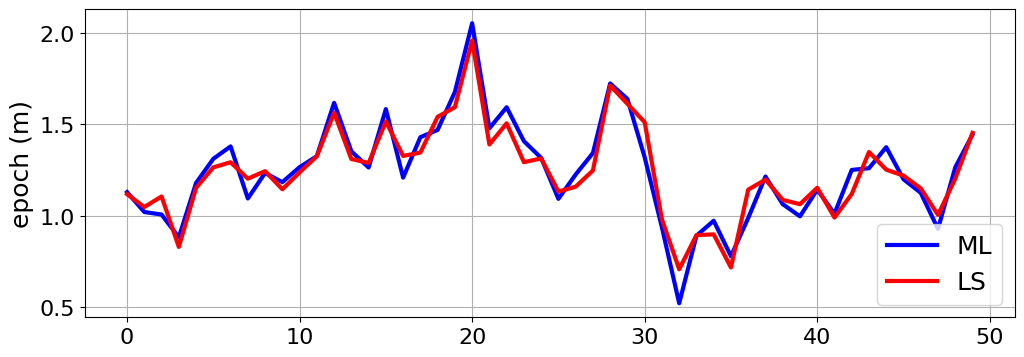

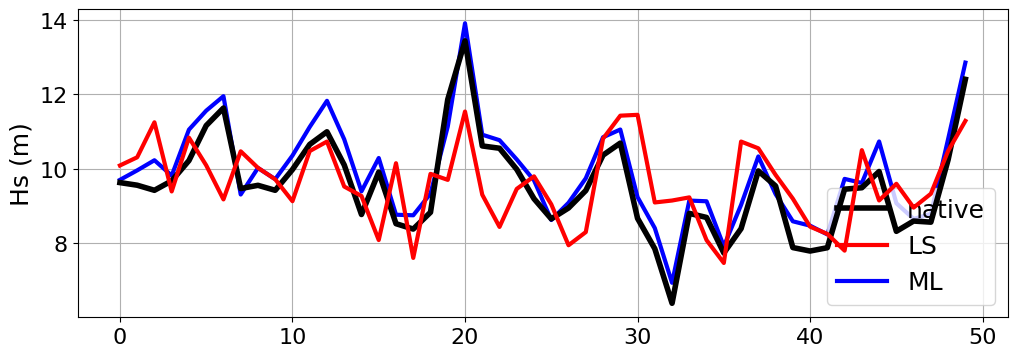

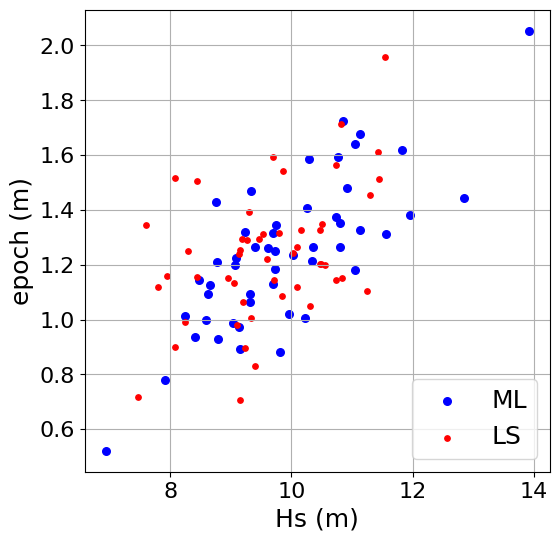

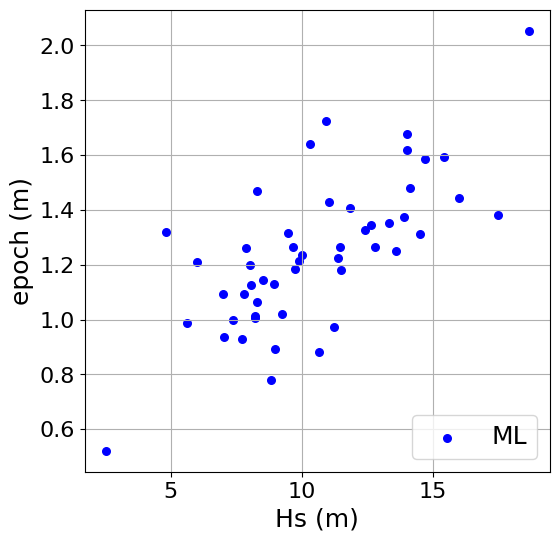

In [6]:
    fig, ax = plt.subplots(figsize=(12,4))
    line2 = ax.plot(ze1.T,color='b',linestyle='-',lw=3,label='ML')
    line3 = ax.plot(ze2.T,color='r',linestyle='-',lw=3,zorder=25,label='LS')
    plt.ylabel('epoch (m)', fontsize=18)
    plt.legend(loc='lower right', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    #fig.savefig('epochs_erf2D.pdf')

    fig, ax = plt.subplots(figsize=(12,4))
    line1 = ax.plot(Hs_native,color='k',linestyle='-',lw=4,zorder=20,label='native')
    line3 = ax.plot(Hs2.T,color='r',linestyle='-',lw=3,zorder=25,label='LS')
    line2 = ax.plot(Hs1.T,color='b',linestyle='-',lw=3,label='ML')
    ax.set_ylabel('Hs (m)', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    leg = ax.legend(loc='lower right', fontsize=18)
    #fig.savefig('Hs_erf2D.pdf')


    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(Hs1.T,ze1.T, s=30, c='blue', vmin=0, vmax=100,label='ML')
    ax.scatter(Hs2.T,ze2.T, s=15, c='red', vmin=0, vmax=100,label='LS')
    #ax.scatter(10+Hs1.T-Hs2.T,ze1.T, s=20, c='green', vmin=0, vmax=100,label='ML')
    plt.ylabel('epoch (m)', fontsize=18)
    plt.xlabel('Hs (m)', fontsize=18)
    plt.legend(loc='lower right', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    #fig.savefig('scatter_erf2D.pdf')

    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(3*Hs1.T-2*Hs2.T,ze1.T, s=30, c='blue', vmin=0, vmax=100,label='ML')
    #ax.scatter(10+Hs1.T-Hs2.T,ze1.T, s=20, c='green', vmin=0, vmax=100,label='ML')
    plt.ylabel('epoch (m)', fontsize=18)
    plt.xlabel('Hs (m)', fontsize=18)
    plt.legend(loc='lower right', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    print('corr:',np.corrcoef(Hs1,ze1)[0,1])
    print('corr:',np.corrcoef(Hs2,ze2)[0,1])
    print('corr:',np.corrcoef(1.5*Hs1-0.5*Hs2,ze1)[0,1])



# Now let's try some different waveform models

box index: 9
(1, 50, 256)
Noise level? 0.0010177956
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00022458364 222.5
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00022458364 222.5
Retracking waveforms 0  out of  1  ------------ 
Retracking result: 9.702422889341047 1.3048731858918141 0.37615931846271033
Retracking result: 9.910716407409799 1.3294858747203262 0.6571917861899845
stds  HS(native,ML,LS): 0.48285604 0.49709216515414645 0.6818624399067307
means Hs(native,ML,LS): 9.31558 9.583518775224574 9.241616087523411 0.25870426265731683 0.4413250422786968
stds   z(native,ML,LS): None 0.15024668437628103 0.14373909839315277
means  z(native,ML,LS): None 1.2267746931276187 1.209259752031054
box index: 35
(1, 50, 256)
Noise level? 0.0010654292
size of waveforms array: 1 50 256 alti_sat: 519000.0
Estimated noise level: 0.00025621202 222.5
Retracking waveforms 0  out of  1  -------

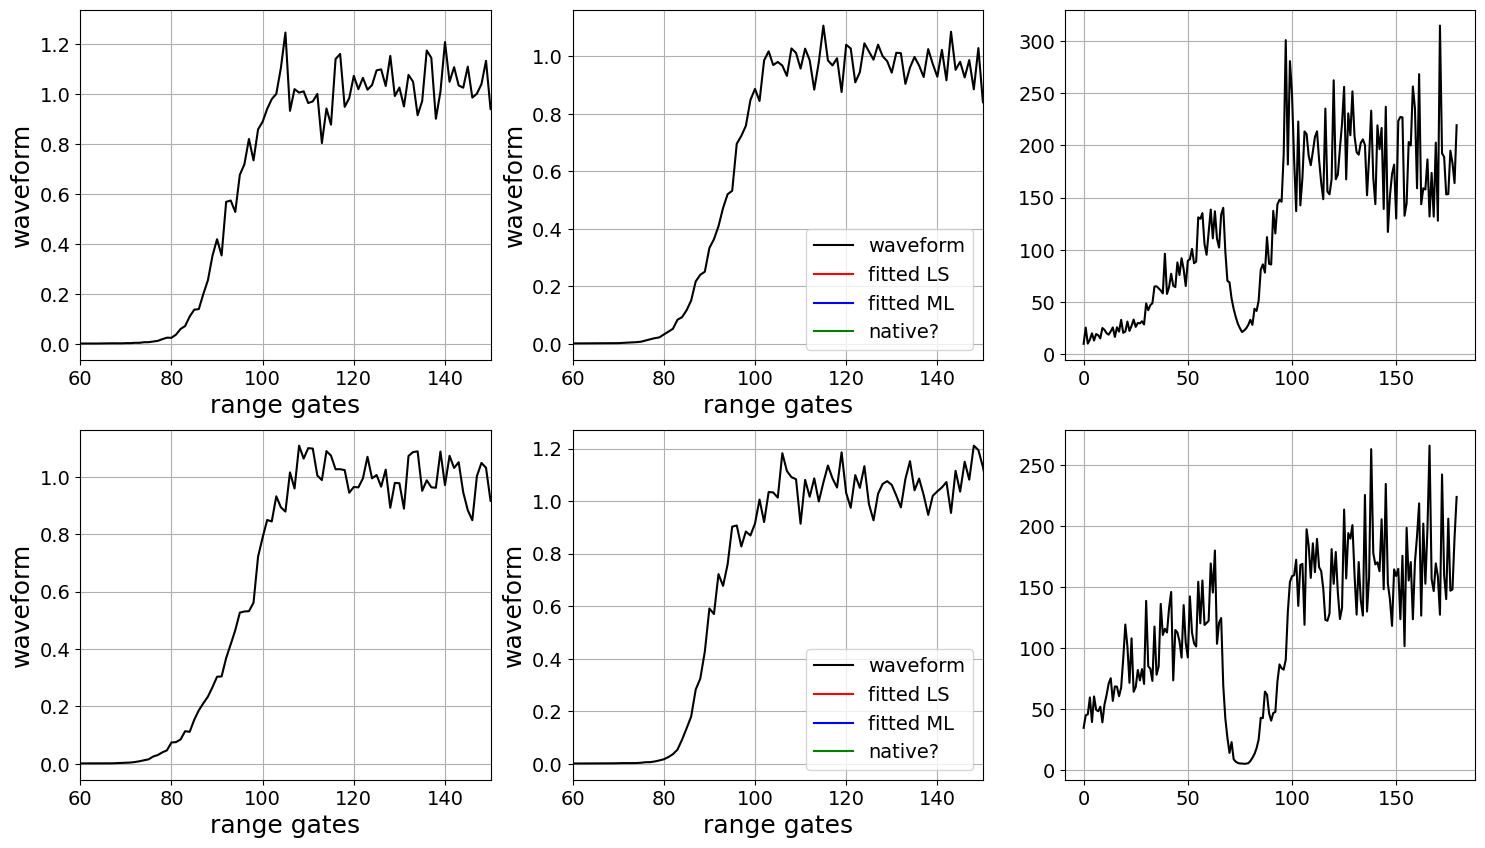

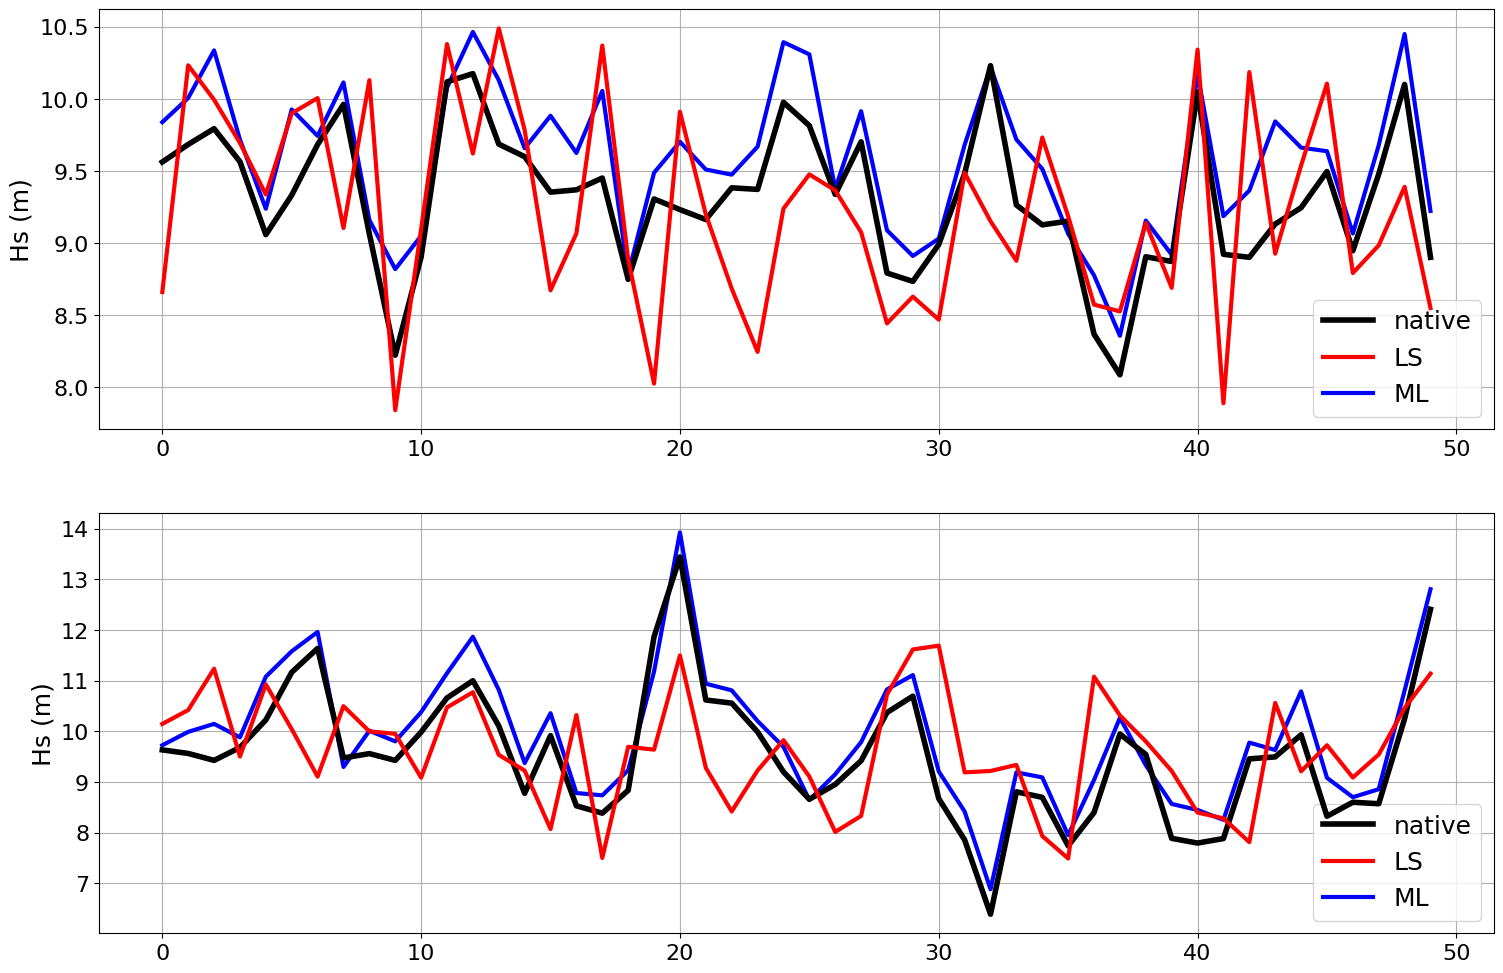

In [7]:
############# Retracking
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.
ialti = 0

theta3dB=theta3dBs[ialti]
alti_sat = Altis[ialti]
bandwidth = BW[ialti]
bandx     = BX[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
nameSat = namesAltis[ialti]
tau=1E9/bandwidth

clight = 299792458
dr = clight * 1/(2*bandwidth)
Rearth=6378.1363*(10**3)      #Earth radius

Earth_sphericity_coeff = (1+alti_sat/Rearth)


is_echo_l1a = 1

if is_echo_l1a:
   wf_model='wf_erf2D'
   var = 'echo_l1a_0'
   max_range_fit=180
   min_range_fit=80
   nominal_tracking_gate=89
   minLS=65
else:
   wf_model='wf_brown'
   var = 'echo_l1_0'
   max_range_fit=300
   min_range_fit=205
   nominal_tracking_gate=220
   minLS=200

range_offset = nominal_tracking_gate*dr  # number of meters above nadir sea level included in waveform

    
issave = 1
fig,axs=plt.subplots(2,3,figsize=(18,10))
fig,axt=plt.subplots(2,1,figsize=(18,12))
jbox=np.array([9,35])
#jbox=np.array([9,18])
#jbox=np.array([18,50])  # max and ow wind
#jbox=np.array([35,9])

ip1=60

ip=20
iq=32

for ibox in range(2):
    kbox=jbox[ibox]
# --- Select indices corresponding to macrocycles of interest ----------------
    inds = get_indices_macrocycles(DS['indices_boxes'].isel(n_box=kbox,n_posneg=1,n_beam_l1a=0))
    print('box index:',kbox)

    ds_l1 = dsl1a.isel(n_mcycles=inds,n_beam=0,n_beam0=0)
    hsat  = ds_l1['altitude']
    Re    = ds_l1['earth_radius']
    nt    = ds_l1['echo_l1_0_nt']
    flag_d= ds_l1['flag_dep_allbeams']
    misp=(ds_l1['alpha_r_p']**2+ds_l1['alpha_t_p']**2)
    Hs_native = DS['nadir_swh_native'].isel(n_mcycles=inds).values
    sig_native = 10**(DS['nadir_sigma0_native'].isel(n_mcycles=inds)/10)

# normalized waveform l1
    wfs = ds_l1[var]/sig_native
    mean_wf = (wfs).mean(dim='n_mcycles',skipna=True)
    std_wf = (wfs).std(dim='n_mcycles')
   
    waveforms=np.expand_dims(wfs, 0)
    print(np.shape(waveforms))
    srat=np.mean(waveforms[0,:,:],axis=0)/np.std(waveforms[0,:,:],axis=0)
    
    misp2    =np.expand_dims(misp, 0)
    [nx,ny,nr]=np.shape(waveforms)
    ranges = np.arange(0,nr*dr,dr)    # remember to increase 35 to higher values if needed
    tax=1E9/bandx
    stonano=1000000000
    rtot=(2./clight)*stonano  #Converts range to time
    times=ranges*rtot
    nr2=int(nr/2)
    t0=tau*(nr2-1)
    PTR=(np.sinc(np.pi*(times-t0)/tax))**2
    s=sum(PTR)
    PTR=PTR/s


    in1=nominal_tracking_gate-40
    in2=nominal_tracking_gate-30
    noise=np.median(np.mean(waveforms[:,:,in1:in2],axis=2))
    print('Noise level?',noise)
    
    wf_model='wf_erf2D'
    mrat=0.06;min_range_fit=50
    Hs1,ze1,Pu1,da1,R01,di1=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='pyramid2',wf_model=wf_model,costfun='ML',\
                                    #min_method='Nelder-Mead',wf_model=wf_model,costfun='LS',\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model=wf_model,costfun='ML',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=min_range_fit,min_gate_rat=mrat,Earth_sphericity_coeff=Earth_sphericity_coeff)
    Hs2,ze2,Pu2,da2,R02,di2=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='pyramid2',wf_model=wf_model,costfun='LS',\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model=wf_model,costfun='LS',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=minLS,min_gate_rat=mrat,Earth_sphericity_coeff=Earth_sphericity_coeff)

    print('Retracking result:',Hs1[0,ip],ze1[0,ip],di1[0,ip])
    print('Retracking result:',Hs2[0,ip],ze2[0,ip],di2[0,ip])
    print('stds  HS(native,ML,LS):',np.std(Hs_native),np.std(Hs1),np.std(Hs2))
    print('means Hs(native,ML,LS):',np.mean(Hs_native),np.mean(Hs1),np.mean(Hs2),np.mean(di1),np.mean(di2))
    print('stds   z(native,ML,LS):',None,np.std(ze1),np.std(ze2))
    print('means  z(native,ML,LS):',None,np.mean(ze1),np.mean(ze2))
    
    wf_fit=wf_eval(ranges,np.array((ze1[0,ip],Hs1[0,ip],Pu1[0,ip],da1[0,ip],R01[0,ip])),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fit2=wf_eval(ranges,np.array((ze2[0,ip],Hs2[0,ip],Pu2[0,ip],da2[0,ip],R02[0,ip])),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    wf_fit3=wf_eval(ranges,np.array((0.,Hs_native[ip],Pu2[0,ip],0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,ip],theta3dB=theta3dB)
    
    wf_fit4=wf_eval(ranges,np.array((ze1[0,iq],Hs1[0,iq],Pu1[0,ip],da1[0,iq],R01[0,iq])),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    wf_fit5=wf_eval(ranges,np.array((ze2[0,iq],Hs2[0,iq],Pu2[0,iq],da2[0,iq],R02[0,iq])),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    wf_fit6=wf_eval(ranges,np.array((0.,Hs_native[iq],Pu2[0,iq],0,0)),clight,wf_model,noise=noise,alti_sat=alti_sat,\
                            PTR_model='True',PTR=PTR,tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=misp2[0,iq],theta3dB=theta3dB)
    ax=axs[ibox,0]
#    line1=ax.plot(ranges[minLS:max_range_fit],waveforms[0,ip,minLS:max_range_fit],color='k',label='waveform')
#    line3=ax.plot(ranges[minLS:max_range_fit],wf_fit2[minLS:max_range_fit],color='r',label='fitted LS')
#    line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit[min_range_fit:max_range_fit],color='b',label='fitted ML')
#    line4=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit3[min_range_fit:max_range_fit],color='g',label='native?')
    line1=ax.plot(range(0,max_range_fit),waveforms[0,ip,0:max_range_fit],color='k',label='waveform')
    line3=ax.plot(range(minLS,max_range_fit),wf_fit2[minLS:max_range_fit],color='r',label='fitted LS')
    line2=ax.plot(range(min_range_fit,max_range_fit),wf_fit[min_range_fit:max_range_fit],color='b',label='fitted ML')
    line4=ax.plot(range(min_range_fit,max_range_fit),wf_fit3[min_range_fit:max_range_fit],color='g',label='native?')
    ax.set_xlim((ip1,150))
    ax.set_xlabel('range gates', fontsize=18)
    ax.set_ylabel('waveform', fontsize=18)
    #ax.set_yscale('log')
    ax=axs[ibox,1]
#    line1=ax.plot(ranges[minLS:max_range_fit],waveforms[0,iq,minLS:max_range_fit],color='k',label='waveform')
#    line3=ax.plot(ranges[minLS:max_range_fit],wf_fit5[minLS:max_range_fit],color='r',label='fitted LS')
#    line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit4[min_range_fit:max_range_fit],color='b',label='fitted ML')
#    line4=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit6[min_range_fit:max_range_fit],color='g',label='native?')
    line1=ax.plot(range(0,max_range_fit),waveforms[0,iq,0:max_range_fit],color='k',label='waveform')
    line3=ax.plot(range(minLS,max_range_fit),wf_fit5[minLS:max_range_fit],color='r',label='fitted LS')
    line2=ax.plot(range(min_range_fit,max_range_fit),wf_fit4[min_range_fit:max_range_fit],color='b',label='fitted ML')
    line4=ax.plot(range(min_range_fit,max_range_fit),wf_fit6[min_range_fit:max_range_fit],color='g',label='native?')
    ax.set_xlim((ip1,150))
    ax.set_xlabel('range gates', fontsize=18)
    ax.set_ylabel('waveform', fontsize=18)
    #ax.set_yscale('log')
    leg = ax.legend(loc='lower right')
    ax=axs[ibox,2]
#    line1=ax.plot(ranges[minLS:max_range_fit],waveforms[0,iq,minLS:max_range_fit],color='k',label='waveform')
#    line3=ax.plot(ranges[minLS:max_range_fit],wf_fit5[minLS:max_range_fit],color='r',label='fitted LS')
#    line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit4[min_range_fit:max_range_fit],color='b',label='fitted ML')
#    line4=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit6[min_range_fit:max_range_fit],color='g',label='native?')
    line1=ax.plot(range(0,max_range_fit),srat[0:max_range_fit]**2,color='k')
    


## ======= Box I ============================================
    ax = axt[ibox]
    line1 = ax.plot(Hs_native,color='k',linestyle='-',lw=4,zorder=20,label='native')
    line3 = ax.plot(Hs2.T,color='r',linestyle='-',lw=3,zorder=25,label='LS')
    line2 = ax.plot(Hs1.T,color='b',linestyle='-',lw=3,label='ML')
    ax.set_ylabel('Hs (m)', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    leg = ax.legend(loc='lower right', fontsize=18)


issave=1    
if issave:
   ax=axs[0,0]
   print('ax:',ax)
   fig = ax.figure 
   fig.savefig('Fig1_waveforms_L1A_SWIM_9_35_22_30_erf2D.pdf')
   ax=axt[0]
   fig = ax.figure 
   fig.savefig('Fig2_Hs_L1A_SWIM_9_35_22_30_erf2D_PTR.pdf')


In [8]:
print(0.015**2/0.02/4)

0.0028125
